In [1]:
!pip install optuna==3.2.0
!pip install gymnasium==0.28.1
!pip install renderlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 24.8 MB/s eta 0:00:00


In [2]:
from typing import Tuple, List, Callable, Union, Optional, Dict
import numpy as np
import os
import pathlib
import imageio
from pathlib import Path
import pandas as pdbb
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from pathlib import Path
from gym.wrappers import RecordVideo
import datetime
import tensorflow as tf
import numpy as np
from tensorflow import keras
from collections import deque
import time
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import os
import optuna
from optuna.importance import get_param_importances
import uuid
import renderlab as rl

/usr/local/lib/python3.10/dist-packages/jaxlib/xla_client.py:225: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  float8_e4m3b11fnuz = ml_dtypes.float8_e4m3b11
  from scipy.ndimage.filters import sobel



In [3]:
def evaluate(
    agent,
    env,
    n_episodes: int,
    observation_space_size: int
) -> Tuple[List, List]:

    # keep track of the reward and steps per episode
    reward_per_episode = []
    steps_per_episode = []

    for i in range(0, n_episodes):

        # reset and initial state from environment needs reshape to np array (tuple instead of array with dimensions 1,4)
        state = np.reshape(env.reset()[0], [1, observation_space_size])

        # initialize the cumulative steps and the rewards for this episode
        rewards = 0
        steps = 0

        # done = environment ended badly / environment ended after 500 episodes
        done = False
        truncated = False

        while not (done or truncated):

            # determine action based on the state
            action = agent.act(state)

            # take the action and observe the reward, new state, etc
            new_state, reward, done, truncated, info = env.step(action)

            # enchange the reward signal
            reward = enhance_reward_signal(new_state, reward, done, truncated, steps)

            # add the data from this step to the episode data
            rewards += reward
            steps += 1

            # reshape the new state
            state = np.reshape(new_state, [1, observation_space_size])

        reward_per_episode.append(rewards)
        steps_per_episode.append(steps)

    return reward_per_episode, steps_per_episode

  and should_run_async(code)



In [4]:
# random agent
class RandomAgent:
    def __init__(self, env):
        self.env = env

    def act(self, state: np.array) -> int:
        return self.env.action_space.sample()

In [5]:
def enhance_reward_signal(next_state, reward, done, truncated, steps):
    if done:
        reward = -100
    elif truncated:
        reward = 100
    elif next_state[0] > 0.2:
        reward = -5
    elif next_state[0] < -0.2:
        reward = -5

    return reward

In [6]:
def record_random_agent():
    # trying the random agent first
    env = gym.make('CartPole-v1',render_mode = "rgb_array")
    env = rl.RenderFrame(env, "./output")

    observation_space_size = env.observation_space.shape[0]

    # create a random agent
    random_agent = RandomAgent(env)

    # evaluate the random agent
    rewards, steps = evaluate(random_agent, env, 5, observation_space_size)

    env.play()

    # evaluation results
    median_steps = np.median(steps)
    mean_steps = np.mean(steps)
    std_steps = np.std(steps)

    print(f'median steps = {median_steps}')
    print(f'std steps    = {std_steps}')
    print(f'mean steps   = {mean_steps}')

    return rewards, steps

In [7]:
def record_trained_agent(agent, env):
    env = rl.RenderFrame(env, "./output")

    observation_space_size = env.observation_space.shape[0]

    # evaluate the random agent
    rewards, steps = evaluate(agent, env, 1, observation_space_size)

    env.play()

In [8]:
# record a random agent
rewards, steps = record_random_agent()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


median steps = 18.0
std steps    = 6.523802572120037
mean steps   = 19.2


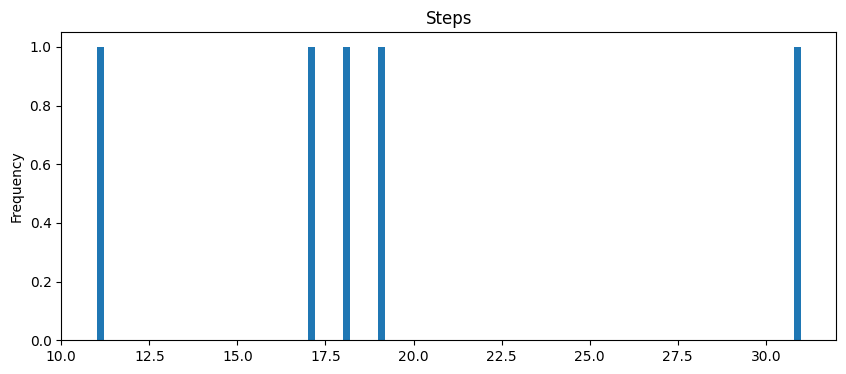

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Steps")
pd.Series(steps).plot(kind='hist', bins=100)

plt.show()

In [10]:
def sample_hyper_parameters(trial: optuna.trial.Trial) -> Dict:

    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256])
    memory_size = trial.suggest_int("memory_size", 500, 10000)
    gamma = trial.suggest_float('gamma', 0.9, 0.99)
    exploration_decay = trial.suggest_categorical('exploration_decay', [0.9, 0.95, 0.98, 0.99])
    layer_size = trial.suggest_categorical('layer_size',[16,32,64,128,256, 512])
    exploration_min = trial.suggest_float('exploration_min',0.001, 0.2)
    episodes = trial.suggest_int("episodes", 10, 20)
    learning_rate = trial.suggest_categorical('learning_rate',[0.001,0.0001])
    extra_intermediate_layers = trial.suggest_categorical('extra_layers',[0,1])

    return {
        'batch_size': batch_size,
        'memory_size': memory_size,
        'gamma': gamma,
        'exploration_decay' : exploration_decay,
        'layer_size' : layer_size,
        'exploration_min' : exploration_min,
        'episodes' : episodes,
        'learning_rate' : learning_rate,
        'extra_intermediate_layers' : extra_intermediate_layers
    }

  and should_run_async(code)



In [11]:
class DeepQAgent:

    def __init__(self, env, memory_size, gamma, exploration_decay, layer_size, batch_size, exploration_min, learning_rate, extra_intermediate_layers = 0, exploration_rate = 1.0):
        self.__env = env
        self.__state_size = 4                                           # we have an 4 numbers that represent our size and this will be the input for our neural net
        self.__action_size = 2                                          # we have 2 possible actions (push the card to the left or to the right)
        self.__memory = deque(maxlen=memory_size)                       # memory for storing our experiences
        self.__layer_size_1 = layer_size                                # nn layer 1 width
        self.__layer_size_2 = layer_size                                # nn layer 2 width
        self.__extra_intermediate_layers = extra_intermediate_layers    # extra intermediate layers?
        self.__learning_rate = learning_rate                            # learning rate
        self.__model = self._build_model()                              # our model
        self.__gamma = gamma                                            # discount rate
        self.__exploration_rate = exploration_rate                      # exploration rate
        self.__exploration_min = exploration_min                        # min value for exploration
        self.__exploration_decay = exploration_decay                    # decay in the exploration rate (moving from exploration to exploitation)
        self.__step_counter = 0                                         # keep track of the steps and update the target model after target_model_delay steps
        self.__sample_batch_size = batch_size                           # how much samples to we take for the learning step
        self.__uuid = str(uuid.uuid4())                                 # unique uid for the model


    def add_to_memory(self, state, action, reward, next_state, done):
        self.__memory.append((state, action, reward, next_state, done))

    def disable_exploration(self):
        self.__exploration_rate = 0
        self.__exploration_min = 0

    def get_agent_uuid(self):
        return self.__uuid

    def save_model(self):
        self.__model.save(f'model-{self.__uuid}.keras')

    def replay(self):

        if len(self.__memory) <= self.__sample_batch_size:
            return
        else:
            mini_batch = random.sample(self.__memory, self.__sample_batch_size)

            current_state = np.zeros((self.__sample_batch_size, self.__state_size))
            next_state = np.zeros((self.__sample_batch_size, self.__state_size))
            target_q_values = np.zeros((self.__sample_batch_size, self.__state_size))

            action = np.zeros(self.__sample_batch_size, dtype=int)
            reward = np.zeros(self.__sample_batch_size)
            done = np.zeros(self.__sample_batch_size,dtype=bool)

            for i in range(self.__sample_batch_size):
                current_state[i] = mini_batch[i][0]   # state
                action[i] = mini_batch[i][1]          # action
                reward[i] = mini_batch[i][2]          # reward
                next_state[i] = mini_batch[i][3]      # next_state
                done[i] = mini_batch[i][4]            # done

            target = self.__model.predict(current_state,verbose=0)
            Qvalue_ns = self.__model.predict(next_state,verbose=0)

            for i in range(self.__sample_batch_size):
                if done[i]:
                    target[i][action[i]] = reward[i]
                else:
                    target[i][action[i]] = reward[i] + self.__gamma * (np.amax(Qvalue_ns[i]))


            self.__model.fit(current_state, target, batch_size=self.__sample_batch_size, epochs=1, verbose=0)

            if self.__exploration_rate > self.__exploration_min:
                self.__exploration_rate *= self.__exploration_decay


    def act(self, state: np.array) -> int:
        if np.random.rand() < self.__exploration_rate:
            random_action = self.__env.action_space.sample()
            return random_action
        else:
            actions = self.__model.predict(state, verbose=0)             # get a model prediction
            best_action = np.argmax(actions[0])                          # get the output index with the highest value
            return best_action

    def _build_model(self):
        model = Sequential()
        model.add(Dense(self.__layer_size_1, input_dim=self.__state_size, activation='relu'))
        model.add(Dense(self.__layer_size_2, activation='relu'))
        if (self.__extra_intermediate_layers > 0):
            for i in range(self.__extra_intermediate_layers + 1):
                model.add(Dense(self.__layer_size_2, activation='relu'))
        model.add(Dense(self.__action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=self.__learning_rate))
        return model

In [12]:
# train loop for the deep q agent
def optimize_train(agent, env, observation_space_size, n_episodes):
    # print('starting traing of agent ...')

    for i in range(0, n_episodes):
        # reset and reshape the state
        state = np.reshape(env.reset()[0], [1, observation_space_size])

        print(f'new train episode {i} on : {datetime.datetime.now()}')

        # initialize done (fail) and truncated (success)
        done = False
        truncated = False

        steps = 0

        while not (done or truncated):

            steps += 1

            # take action based on the state
            action = agent.act(state)

            # observe the signal from the environment after the action
            next_state, reward, done, truncated, info = env.step(action)

            # enhance the signal and merge the truncated and done signals
            reward = enhance_reward_signal(next_state, reward, done, truncated, steps)

            if done:
                print(f'ended training episode with mistake and reward {reward} and step count {steps}')
            elif truncated:
                print(f'ended training episode with success and reward {reward} and step count {steps}')

            next_state = np.reshape(next_state, [1, observation_space_size])

            # add the observation to the memory
            agent.add_to_memory(state, action, reward, next_state, done)

            # replay observations from the memory and learn if needed
            agent.replay()

            # replace the current state
            state = next_state

In [13]:
def objective(trial: optuna.trial.Trial) -> float:

    # create an environment
    env = gym.make('CartPole-v1',render_mode = "rgb_array")

    # fetch properties from environment
    observation_space_size = env.observation_space.shape[0]
    action_space_size = env.action_space.n

    print(f'observation space size : {observation_space_size}')
    print(f'action space size      : {action_space_size}')

    # get the hyper parameter config
    args = sample_hyper_parameters(trial)

    print(f'optuna run with params started with params : {trial.params}')

    # create the deep agent
    deep_agent = DeepQAgent(
        env,
        memory_size = args['memory_size'],
        gamma = args['gamma'],
        exploration_decay = args['exploration_decay'],
        layer_size = args['layer_size'],
        batch_size = args['batch_size'],
        exploration_min = args['exploration_min'],
        learning_rate = args['learning_rate'],
        extra_intermediate_layers = args['extra_intermediate_layers']
    )

    print('train loop started')

    # reset all
    env.reset()

    # train loop
    optimize_train(deep_agent,env, observation_space_size,n_episodes=args['episodes'])

    # disable exploitation and only rely on the model for decisions
    deep_agent.disable_exploration()

    print('evaluation started')
    rewards, steps = evaluate(deep_agent, env, 50, observation_space_size)

    # evaluation results
    median_steps = np.median(steps)
    mean_steps = np.mean(steps)
    std_steps = np.std(steps)

    median_reward = np.median(rewards)
    mean_reward = np.mean(rewards)
    std_reward= np.std(rewards)


    print(f'median reward = {median_reward}')
    print(f'std reward    = {std_reward}')
    print(f'mean reward   = {mean_reward}')

    print(f'median steps = {median_steps}')
    print(f'std steps    = {std_steps}')
    print(f'mean steps   = {mean_steps}')

    # record the agent
    record_trained_agent(deep_agent,env)

    # clear all the memory
    keras.backend.clear_session()

    return median_reward

In [14]:
# create an optimized model
study_name = "rl-study"
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True)

study.optimize(objective, n_trials=3, gc_after_trial=True)

[I 2023-07-03 12:12:44,069] A new study created in RDB with name: rl-study


observation space size : 4
action space size      : 2
optuna run with params started with params : {'batch_size': 16, 'memory_size': 7307, 'gamma': 0.9360629306357108, 'exploration_decay': 0.98, 'layer_size': 128, 'exploration_min': 0.09183136782922015, 'episodes': 14, 'learning_rate': 0.001, 'extra_layers': 1}
train loop started
new train episode 0 on : 2023-07-03 12:12:48.092092
ended training episode with mistake and reward -100 and step count 33
new train episode 1 on : 2023-07-03 12:12:59.630754
ended training episode with mistake and reward -100 and step count 15
new train episode 2 on : 2023-07-03 12:13:02.961098
ended training episode with mistake and reward -100 and step count 9
new train episode 3 on : 2023-07-03 12:13:04.468100
ended training episode with mistake and reward -100 and step count 12
new train episode 4 on : 2023-07-03 12:13:07.238405
ended training episode with mistake and reward -100 and step count 8
new train episode 5 on : 2023-07-03 12:13:08.999607
ended tr

Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


[I 2023-07-03 12:18:43,347] Trial 0 finished with value: -119.0 and parameters: {'batch_size': 16, 'episodes': 14, 'exploration_decay': 0.98, 'exploration_min': 0.09183136782922015, 'extra_layers': 1, 'gamma': 0.9360629306357108, 'layer_size': 128, 'learning_rate': 0.001, 'memory_size': 7307}. Best is trial 0 with value: -119.0.


observation space size : 4
action space size      : 2
optuna run with params started with params : {'batch_size': 256, 'memory_size': 4786, 'gamma': 0.9326412403219556, 'exploration_decay': 0.99, 'layer_size': 512, 'exploration_min': 0.019502189092526413, 'episodes': 16, 'learning_rate': 0.001, 'extra_layers': 0}
train loop started
new train episode 0 on : 2023-07-03 12:18:44.195941
ended training episode with mistake and reward -100 and step count 24
new train episode 1 on : 2023-07-03 12:18:44.198549
ended training episode with mistake and reward -100 and step count 26
new train episode 2 on : 2023-07-03 12:18:44.200636
ended training episode with mistake and reward -100 and step count 14
new train episode 3 on : 2023-07-03 12:18:44.202412
ended training episode with mistake and reward -100 and step count 14
new train episode 4 on : 2023-07-03 12:18:44.203909
ended training episode with mistake and reward -100 and step count 14
new train episode 5 on : 2023-07-03 12:18:44.205406
ende

Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


[I 2023-07-03 12:21:21,150] Trial 1 finished with value: -52.0 and parameters: {'batch_size': 256, 'episodes': 16, 'exploration_decay': 0.99, 'exploration_min': 0.019502189092526413, 'extra_layers': 0, 'gamma': 0.9326412403219556, 'layer_size': 512, 'learning_rate': 0.001, 'memory_size': 4786}. Best is trial 1 with value: -52.0.


observation space size : 4
action space size      : 2
optuna run with params started with params : {'batch_size': 32, 'memory_size': 3586, 'gamma': 0.9831282740627535, 'exploration_decay': 0.95, 'layer_size': 128, 'exploration_min': 0.1304504914816747, 'episodes': 13, 'learning_rate': 0.0001, 'extra_layers': 0}
train loop started
new train episode 0 on : 2023-07-03 12:21:21.727093
ended training episode with mistake and reward -100 and step count 15
new train episode 1 on : 2023-07-03 12:21:21.728517
ended training episode with mistake and reward -100 and step count 43
new train episode 2 on : 2023-07-03 12:21:26.809875
ended training episode with mistake and reward -100 and step count 27
new train episode 3 on : 2023-07-03 12:21:31.560866
ended training episode with mistake and reward -100 and step count 17
new train episode 4 on : 2023-07-03 12:21:34.431635
ended training episode with mistake and reward -100 and step count 27
new train episode 5 on : 2023-07-03 12:21:39.597639
ended 

Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


[I 2023-07-03 12:23:20,852] Trial 2 finished with value: -81.5 and parameters: {'batch_size': 32, 'episodes': 13, 'exploration_decay': 0.95, 'exploration_min': 0.1304504914816747, 'extra_layers': 0, 'gamma': 0.9831282740627535, 'layer_size': 128, 'learning_rate': 0.0001, 'memory_size': 3586}. Best is trial 1 with value: -52.0.


In [15]:
# print param importances
print(get_param_importances(study))

OrderedDict([('batch_size', 0.17756755698420398), ('memory_size', 0.16939038254815356), ('extra_layers', 0.1502560335852079), ('exploration_decay', 0.14652112540733295), ('episodes', 0.12789510781885702), ('layer_size', 0.07659851767020892), ('exploration_min', 0.07641707403349417), ('learning_rate', 0.039148582366312024), ('gamma', 0.036205619586229455)])


In [16]:
df = study.trials_dataframe()
df.head(20)

  and should_run_async(code)



,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_episodes,params_exploration_decay,params_exploration_min,params_extra_layers,params_gamma,params_layer_size,params_learning_rate,params_memory_size,state
0,0,-119.0,2023-07-03 12:12:44.083711,2023-07-03 12:18:43.177714,0 days 00:05:59.094003,16,14,0.98,0.091831,1,0.936063,128,0.0010,7307,COMPLETE
1,1,-52.0,2023-07-03 12:18:43.973555,2023-07-03 12:21:21.122447,0 days 00:02:37.148892,256,16,0.99,0.019502,0,0.932641,512,0.0010,4786,COMPLETE
2,2,-81.5,2023-07-03 12:21:21.560651,2023-07-03 12:23:20.797663,0 days 00:01:59.237012,32,13,0.95,0.130450,0,0.983128,128,0.0001,3586,COMPLETE


In [17]:
study.best_params

  and should_run_async(code)



{'batch_size': 256,
 'episodes': 16,
 'exploration_decay': 0.99,
 'exploration_min': 0.019502189092526413,
 'extra_layers': 0,
 'gamma': 0.9326412403219556,
 'layer_size': 512,
 'learning_rate': 0.001,
 'memory_size': 4786}